This notebook has evolved from a previous one made for the same competition, where I used linear regression and manually transferred over the features.
The ouput from that method achieved an RMSE of 0.18125.

Some of the code is ported, other parts are largely overhauled. Let's see what I can improve before moving to neural networks.

In [1]:
# general packages
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns    # this is only for the heatmap for the confusion matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# data packages
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

if pd.__version__ != '1.2.4':
    !pip install -U scikit-learn

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test  = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

inputs = [df_train, df_test]

df_train.head()

# lots of missing features and non-numerical ones.
# plenty of cleaning needed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Cleaning the datasets

- translating into numerical form
- replacing or removing any missing values

In [3]:
print(len(df_train.dtypes[df_train.dtypes == np.object]), 'rows need conversion.')

object_cols = []
for col in df_train.columns[df_train.dtypes == np.object]:
    object_cols.append(col)

# loads of object columns that will need converting over or dropping, luckily I've learned that
# sklearn can transfer over with the label encoder, so I don't have to slog through it (again!).

# the encoder can't handle missing numbers, but I don't want to deal with them just yet, instead
# I'll assign a dummy variable and shift it back to NaN after the transfer

encoder = preprocessing.LabelEncoder()

def encoding_col(dataframe_in, col_str):
    
    '''Takes the columns and shifts them to numerical values. 
    Converts missing values through and won\'t follow the organisation
    of the text file.'''
    
    NaN_sum = dataframe_in[col_str].isna().sum()                                         # checked here, as it changes otherwise
    
    if NaN_sum > 0:                                                                      # replace nan values if the column has them
        dataframe_in[col_str].replace(np.nan, 'missing', inplace=True)                   # converts any NaN to a usable value for labels
    
    col_labels = list(dict.fromkeys(dataframe_in[col_str].sort_values(ascending=True)))  # generates the refined list of labels

    encoder.fit(col_labels)
    
    if NaN_sum > 0:                                                                      # replace nan values if the column has them
        inverse_transform = encoder.transform(['missing'])                               # translates the NaN back in right at the end
        
    encoded_arr = encoder.transform(dataframe_in[col_str].to_list())                     
    
    if NaN_sum > 0:
        return np.where(encoded_arr==inverse_transform, np.nan, encoded_arr)              # translates the NaN back in right at the end
    else:
        return encoded_arr


for column in object_cols:
    for dframe in inputs:
        dframe[column] = encoding_col(dframe, column)
        
print(len(df_train.dtypes[df_train.dtypes == np.object]), 'rows need further conversion.')

43 rows need conversion.
0 rows need further conversion.


In [4]:
# Now necessary to asses the missing values in each df
# all the NaN columns in the training df, quite a few
nan_cols = []
for i in df_train.columns:
    if df_train[i].isnull().values.any()==True:
        nan_cols.append(i)

print(df_train.isna().sum().sum(), 'cases of NaN in the df.')
# best way to deal with these?
print(nan_cols)

6965 cases of NaN in the df.
['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


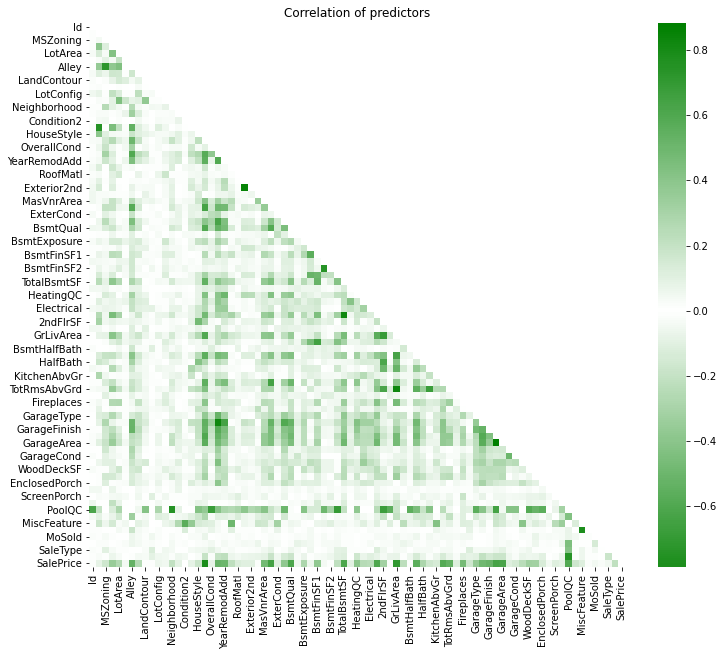

In [5]:
# seeing if there's obvious correlations between predictors, good for feature reduction
corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap=LinearSegmentedColormap.from_list('gwg',["g", "w", "g"], N=256) , mask=mask, center=0)
plt.title("Correlation of predictors")
plt.show()

# A couple that do seem to have good relations, others that just show no relation
# definitely a good time to use PCA

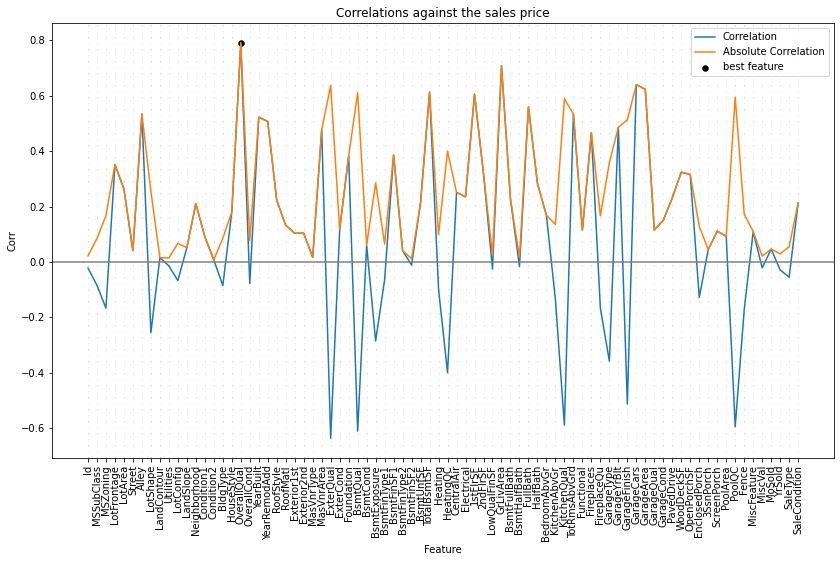

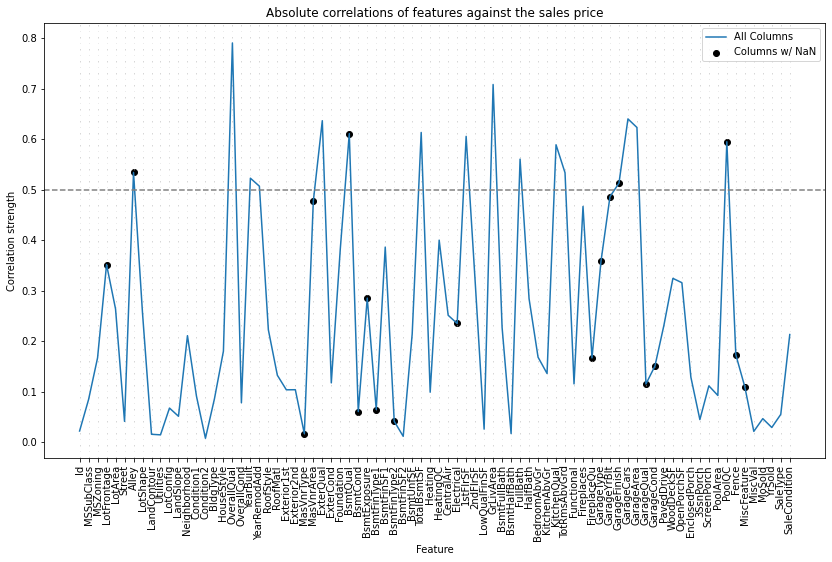

In [6]:
corrs_view = corr['SalePrice']

fig = plt.figure(figsize=(14,8))
plt.title('Correlations against the sales price')
plt.ylabel('Corr')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)

plt.plot(corrs_view[0:-1], label='Correlation')
plt.plot(np.abs(corrs_view[0:-1]), label='Absolute Correlation')
plt.axhline(0, c='gray')
plt.scatter(corr['SalePrice'][0:-1].argmax(),corr['SalePrice'][0:-1].max(),
            linewidth = 0.4, c='black', label='best feature')
plt.legend()
plt.show()

# viewing only the correlation of these columns against the sales price, to see if removal is an awful idea

fig = plt.figure(figsize=(14,8))
plt.title('Absolute correlations of features against the sales price')
plt.ylabel('Correlation strength')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)

plt.plot(np.abs(corrs_view[0:-1]), label='All Columns')
plt.scatter(corrs_view[nan_cols].index, np.abs(corrs_view[nan_cols]), c='black', label='Columns w/ NaN')
plt.axhline(0.5, c='gray', linestyle='--')
plt.legend()
plt.show()
# some of the features are quite valuable, there are 3 with a correlation greater than 0.5 and another 3 over 0.4
# it's certainly worth trying to keep the most valuable ones

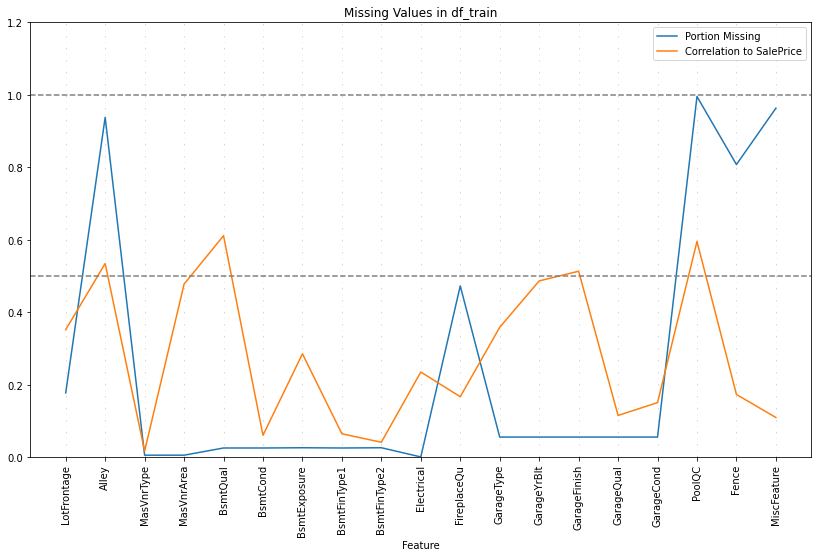

In [7]:
# observing the number of missing values in these columns, if there are loads, they might be worth dropping outright.
# lower correlation ones can be tuned out by RFE or PCA.

nans_in_col = []
nans_in_col_frac = []

for column in nan_cols:
    nans_in_col.append(df_train[column].isna().sum())
    nans_in_col_frac.append(df_train[column].isna().sum()/len(df_train))
    
fig = plt.figure(figsize=(14,8))
plt.title('Missing Values in df_train')
#plt.ylabel('# Missing')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)

plt.plot(nan_cols, nans_in_col_frac, label = 'Portion Missing')
plt.plot(nan_cols, np.abs(corrs_view[nan_cols]), label = 'Correlation to SalePrice')
plt.ylim(0,1.2)

plt.axhline(0.5, c='gray', linestyle='--')
plt.axhline(1, c='gray', linestyle='--')
plt.legend()

In [8]:
#print(df_train.FireplaceQu[df_train.Fireplaces!=0].isna().sum(), df_test.FireplaceQu[df_test.Fireplaces!=0].isna().sum())
#print('no true missing FireplaceQu values')
# now can just bluntly replace all other NaN values without risk

# replacing the true NaN values so they're not accidentally replaced in a less precise method after
bool_poolqc = df_test.PoolQC[df_test.PoolArea!=0].isna()   
bad_nan_locs = bool_poolqc[bool_poolqc].index
df_test.loc[bad_nan_locs, 'PoolQC'] = -1
# now can just bluntly replace all other NaN values without risk

for dataframe in inputs:
    
    # the easily cleaned features here, the NaNs really represent an outcome
    
    alley_max = dataframe.Alley.max()                  # assigning the NaNs as the new highest value in the 
    fence_max = dataframe.Fence.max()                  # encoded values, this isn't reversible though
    miscF_max = dataframe.MiscFeature.max()
    
    dataframe['Alley'].fillna(alley_max+1, inplace=True)
    dataframe['Fence'].fillna(fence_max+1, inplace=True)
    dataframe['MiscFeature'].fillna(miscF_max+1, inplace=True)
    
    # now for the features where they may be valid under certain requirements
    
    fireQ_max = dataframe.FireplaceQu.max()
    pooQC_max = dataframe.PoolQC.max()
    
    #dataframe[dataframe['Fireplaces']==0].FireplaceQu.fillna(fireQ_max+1, inplace=True)
    #dataframe[dataframe['PoolArea']==0].PoolQC.fillna(pooQC_max+1, inplace=True)
    
    fire_req = dataframe['Fireplaces']==0
    pool_req = dataframe['PoolArea']==0
    
    #dataframe.loc[fire_req, 'FireplaceQu'].fillna(fireQ_max+1, inplace=True)

    dataframe.FireplaceQu.fillna(fire_req+1, inplace=True)
    dataframe.PoolQC.fillna(pooQC_max+1, inplace=True)

# returning the bad missing values in PoolQC
df_test.PoolQC.replace(-1, np.nan, inplace=True)

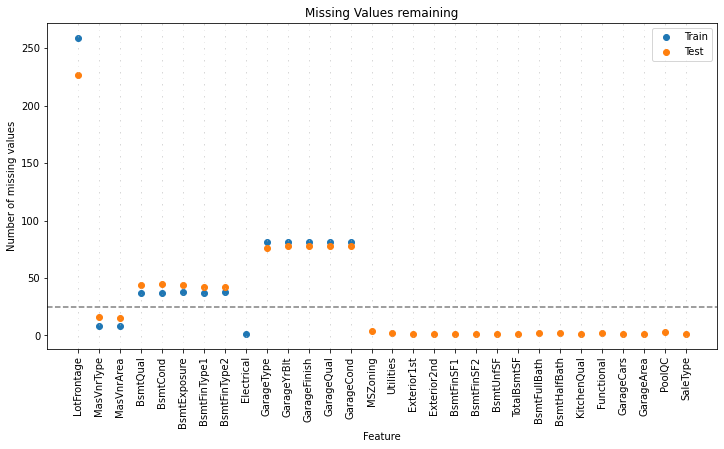

In [9]:
# now need to see what missing values exist in each set and where, whatever's left may well be worth dropping

nan_cols_tr = []
nan_cols_te = []

for i in df_train.columns[:-1]:
    
    if df_train[i].isnull().values.any()==True:
        nan_cols_tr.append(i)
        
    if df_test[i].isnull().values.any()==True:
        nan_cols_te.append(i)  
        
nans_in_col_tr = []
for column in nan_cols_tr:
    nans_in_col_tr.append(df_train[column].isna().sum())
    
nans_in_col_te = []
for column in nan_cols_te:
    nans_in_col_te.append(df_test[column].isna().sum())

    
def missing_val_graph():
    
    nan_cols_tr = []
    nan_cols_te = []

    for i in df_train.columns[:-1]:

        if df_train[i].isnull().values.any()==True:
            nan_cols_tr.append(i)

        if df_test[i].isnull().values.any()==True:
            nan_cols_te.append(i)  

    nans_in_col_tr = []
    for column in nan_cols_tr:
        nans_in_col_tr.append(df_train[column].isna().sum())

    nans_in_col_te = []
    for column in nan_cols_te:
        nans_in_col_te.append(df_test[column].isna().sum())
    
    fig = plt.figure(figsize=(12,6))
    plt.title('Missing Values remaining')
    plt.xlabel('Feature')
    plt.ylabel('Number of missing values')
    plt.xticks(rotation=90)
    plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)
    plt.axhline(25, c='gray', linestyle='--')  
    # features with enough missing values to possibly offer problems if I just fill them out with an average
    plt.scatter(nan_cols_tr, nans_in_col_tr, label = 'Train')
    plt.scatter(nan_cols_te, nans_in_col_te, label = 'Test')
    plt.legend()
    plt.show()
    
missing_val_graph()

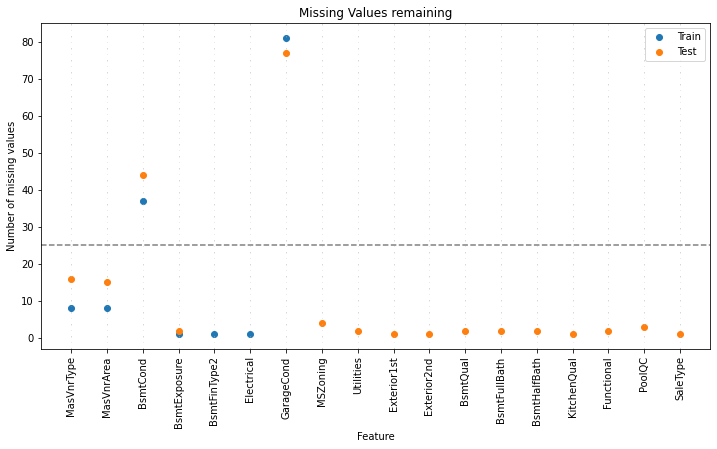

In [10]:
for dataframe in inputs:
    dataframe.drop('LotFrontage', axis=1, inplace=True)
    
# cross reference feature for the bsmt and garage sets is just if they have 'GarageCond' or 'BsmtCond'
basement_list = ['BsmtQual','BsmtExposure','BsmtFinType1', 'BsmtFinType2','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
garage_list = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCars','GarageArea']


for dataframe in inputs:
    init_lineup = dataframe['BsmtCond'].isnull()

    combi_region = dataframe['BsmtFinType1'].isnull() & dataframe['BsmtFinSF1'].isnull()
    dataframe.loc[combi_region, 'BsmtFinType1'] = dataframe['BsmtFinType1'].max()+1

    for feat1 in basement_list:
        combi_region = dataframe[feat1].isnull() & init_lineup
        dataframe.loc[combi_region, feat1] = dataframe[feat1].max()+1

    dataframe.loc[combi_region, 'BsmtCond'] = dataframe['BsmtCond'].max()+1
    
    
    init_lineup = dataframe['GarageCond'].isnull()

    #combi_region = dataframe['BsmtFinType1'].isnull() & dataframe['BsmtFinSF1'].isnull()
    #dataframe.loc[combi_region, 'BsmtFinType1'] = dataframe['BsmtFinType1'].max()+1

    for feat1 in garage_list:
        combi_region = dataframe[feat1].isnull() & init_lineup
        dataframe.loc[combi_region, feat1] = dataframe[feat1].max()+1

    dataframe.loc[combi_region, 'GarageCond'] = dataframe['GarageCond'].max()+1

missing_val_graph()

In [11]:
# to remove the NaN's again, I'll look to take the average from the most correlated features,
# using the original correlation, NOT a new one. However, must be vigilant of using columns
# that also have missing values

corr_new = df_train.corr()
corr_new.drop('SalePrice',   inplace=True)
corr_new.drop('SalePrice',   axis=1, inplace=True)

def most_correlated(feature_in, feat_no):
    '''Provides a selected number of most correlated features 
    and their absolute values. Useful for selecting feat2'''
    
    corr_values = (np.abs(corr_new[feature_in])).sort_values(ascending=False)[1:feat_no+1]
    
    return(corr_values)

In [12]:
def filler_from_corr(dataframe, feat1, feat2, verbose=False):
    
    '''Cleans the missing values in a column (feat1) for a given dataframe,
    taking the expected value for that feature using the average/median of 
    the most correlated feature (feat2).'''
    
    # Given dataframe so it can be performed on both train and test as wanted, 
    # but not for looping.
    # Given most correlated feature to remove the need for repeated calculation.
    
    if dataframe[feat1].isna().sum() == 0:
        print(feat1,'No values to replace, exiting.')
        return
    
    if verbose==True:        # mostly for tests
        print(dataframe[feat1].isna().sum(), 'missing vals in', feat1, 'going in.')
        
    feat2of1 = dataframe.loc[dataframe[feat1].isna(),feat2]         # all the values for feat2 of the rows that have nans in feat1
    feat2of1.dropna(inplace=True)                                  # don't want them working into the values if they're common
    
    feat2_vals = list( dict.fromkeys(feat2of1.sort_values(ascending=True))) # refining to non-repeated values, to be worked through
    # feat2_vals describes all the values of feat2 that map to a missing feat1 value, find the feat1 average of these and plug it in
    
    df_feat1_nans = dataframe[pd.isna(dataframe[feat1])]                    # the rows that want replacing
    df_train_good = df_train.dropna(subset = [feat1])[[feat1, feat2]]       # for calculating the average with regards to the training set
    df_feat1_good = dataframe.dropna(subset = [feat1])                      # must drop rows with the nans for recombination
    
    if len(df_train_good)==0:
        # in the event that there are no suitable values to be generated from feat2 related rows,
        # just return and change to the next most relevant feat2
        print('No viable replacements, try a different feat2')
        return
    
    all_clean_feat1 = []
    
    for i in feat2_vals:
        
        mean_val = (df_train_good[df_train_good[feat2]==i])[feat1].mode().mean()
        
        if mean_val != mean_val:
            if verbose==True:        # mostly for tests
                print(i, 'Not a good relation, running large-scale mean.')
                
            mean_val = df_train_good[feat1].mode().mean()
            feat1_mean = int(mean_val)
            
        else:
            feat1_mean = int(mean_val)
            
        #print(feat1_mean)
        
        # finds the most common type of the first feature for each of the second feature's values
        # (cannot use mean due to discrete labels >{0,1})
        # the output is also rounded to an int just for conformity.

        cleaned_feat1 = df_feat1_nans[df_feat1_nans[feat2]==i][feat1].fillna(feat1_mean)
        all_clean_feat1.append(cleaned_feat1)      
    
    #print(feat2_vals)
    #print(len(all_clean_feat1))
    
    dataframe[feat1] = pd.concat([df_feat1_good[feat1], pd.concat(all_clean_feat1)])
    
    if verbose==True:        # mostly for tests - also relevant to complete cleaning
        print(dataframe[feat1].isna().sum(), 'missing vals in', feat1, 'coming out.')
        
    return

In [13]:
# To use the filler_from_corr function, must first find all the next most related feature.
# This has to be done seperately for test and train, as they have different missing values.

df_train_corrs = []
df_test_corrs = []

nan_cols_tr.pop(0)     # removing lot frontage
nan_cols_te.pop(1)

for feat1 in nan_cols_tr[1:]:
    
    feature_correlations = most_correlated(feat1,3)
    corr_feat_name = feature_correlations.index[0]
    corr_feat_val  = feature_correlations[0]
    
    df_train_corrs.append((feat1, corr_feat_name))#, corr_feat_val))

for feat1 in nan_cols_te[1:]:
    
    feature_correlations = most_correlated(feat1,3)
    corr_feat_name = feature_correlations.index[0]
    corr_feat_val  = feature_correlations[0]
    
    df_test_corrs.append((feat1, corr_feat_name))#, corr_feat_val))
    
df_train_corrs[-2]=['GarageQual','YearBuilt'] # otherwise it's too self referential
df_train_corrs[-1]=['GarageCond','YearBuilt'] # otherwise it's too self referential

for i in range(len(df_train_corrs)):
    filler_from_corr(df_train, df_train_corrs[i][0], df_train_corrs[i][1], verbose=False)

df_test_corrs[1]=['Exterior1st','HeatingQC'] # otherwise it's too self referential
df_test_corrs[21]=['GarageCars', 'OverallQual'] # otherwise it's too self referential
df_test_corrs[25]=['GarageQual','GarageYrBl']  # otherwise it's too self referential

#for i in range(23): # problems with later ones, just gonna gloss over them for now
for i in range(len(df_test_corrs)):
    filler_from_corr(df_test, df_test_corrs[i][0], df_test_corrs[i][1], verbose=False)

BsmtQual No values to replace, exiting.
BsmtFinType1 No values to replace, exiting.
GarageType No values to replace, exiting.
GarageYrBlt No values to replace, exiting.
GarageFinish No values to replace, exiting.
GarageQual No values to replace, exiting.
BsmtFinType1 No values to replace, exiting.
BsmtFinSF1 No values to replace, exiting.
BsmtFinType2 No values to replace, exiting.
BsmtFinSF2 No values to replace, exiting.
BsmtUnfSF No values to replace, exiting.
TotalBsmtSF No values to replace, exiting.
GarageType No values to replace, exiting.
GarageYrBlt No values to replace, exiting.
GarageFinish No values to replace, exiting.
GarageCars No values to replace, exiting.
GarageArea No values to replace, exiting.
GarageQual No values to replace, exiting.
GarageQual No values to replace, exiting.


In [14]:
# the last values are not easy to pin down, but they're a very small 
# component of the system so can be done more bluntly than before

#rint('df_train drops',df_train.shape[0]-df_train.dropna().shape[0],'rows of',df_train.shape[0])
#df_train.dropna(inplace=True)

mean_val = df_train['MasVnrType'].mode().mean()
df_train['MasVnrType'].fillna(mean_val, inplace=True)

nan_cols_te = []
for i in df_test.columns:
    if df_test[i].isnull().values.any()==True:
        nan_cols_te.append(i)  

for feat1 in nan_cols_te:
    mean_val = df_test[feat1].mode().mean()
    df_test[feat1].fillna(mean_val, inplace=True)
    
for dataframe in inputs:
    print(dataframe.isna().sum().sum(), 'missing vals.')

0 missing vals.
0 missing vals.


## Sorting the datasets for a model

Most models like to have the data normalised, and the SalePrice should be checked for skewness.

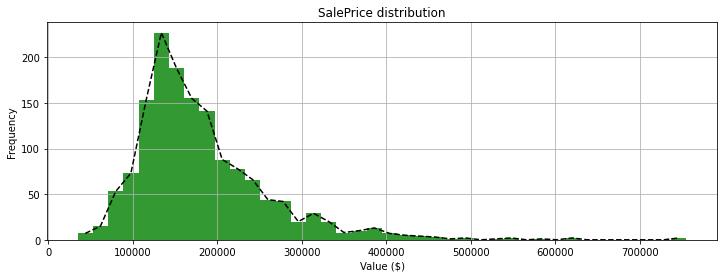

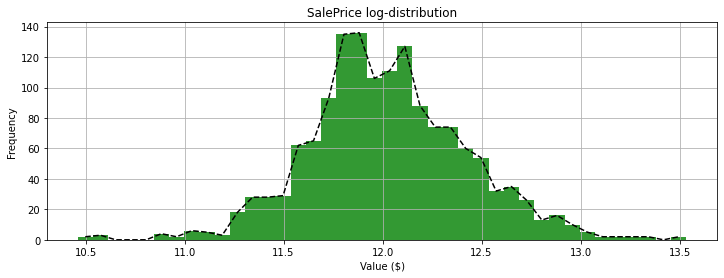

In [15]:
# not very experienced with histograms but this'll just give an easy way to see the saleprice distribution

def histo_func(X_list, bins_no, title='SalePrice distribution'):
    fig = plt.figure(figsize=(12,4))
    n, bins, patches = plt.hist(X_list, bins_no, facecolor='g', density=False, alpha=0.8)
    bin_center = bins[:-1] + np.diff(bins) / 2

    plt.xlabel('Value ($)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.plot(bin_center,n,'--',c='black')
    plt.show()

histo_func(df_train['SalePrice'], 40)
histo_func(np.log1p(df_train['SalePrice']), 40, title='SalePrice log-distribution')

# the initial feature is skewed very heavily, but the log is not, 
# take these values to improve the capacity of the sklearn algorithms, must reverse this at the end!

In [16]:
X = df_train.drop(['SalePrice'], axis=1)
y = df_train[['SalePrice']]
y = np.log1p(y)

# should scale data before PCA

st_scaler = StandardScaler().fit(X)        # fit to training set and apply to both
#st_scaler = MinMaxScaler().fit(X)
X = st_scaler.transform(X)
X_df_test = st_scaler.transform(df_test)   # repeat the rescaling to the X values for the test set

mm_scaler = MinMaxScaler().fit(y)          # will want to view the y out so will need inversion later
#mm_scaler = StandardScaler().fit(y)
y = mm_scaler.transform(y)                 # mm_scaler.inverse_transform(y)

# The reversion method:

#histo_func(y, 40, title='SalePrice log-distribution')
#histo_func(np.expm1(mm_scaler.inverse_transform(y)), 40, title='SalePrice log-distribution')

In [17]:
# worth generating a smaller test-train split to check the quality of the model against itself before entering into the blind test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

pca = PCA(.98)        # maintaining 95% of the variance of the original features, could easily drop to ~80% without issue

pca.fit(X_train)
principalComp_tr = pca.transform(X_train)
principalComp_te = pca.transform(X_test)

X_train_pca = pd.DataFrame(data = principalComp_tr)
X_test_pca = pd.DataFrame(data = principalComp_te)

print(df_train.shape[1], 'features drops to', X_train_pca.shape[1])

80 features drops to 66


In [18]:
regr = RandomForestRegressor(bootstrap=True, oob_score=True, n_jobs=-1, random_state=5)

# Fit the tree to training data
regr.fit(X_train_pca,y_train.ravel())
regr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [19]:
nodes = []
max_depths = []

for single_tree in regr.estimators_:
    nodes.append(single_tree.tree_.node_count)
    max_depths.append(single_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# these trees really overfit, they're very complex. For reference, there are 1168 rows in the training set
# too complex to plot easily to be honest!

if 0==1:
    example_tree = regr.estimators_[1]

    plt.figure(figsize=(16,12))
    tree.plot_tree(example_tree)  
    plt.show()

Average number of nodes 1404
Average maximum depth 20


In [20]:
# competition will use RMSE to judge the model, so best to use that here too
y_train_pred = regr.predict(X_train_pca)
y_test_pred  = regr.predict(X_test_pca)

print(mean_squared_error(y_train, y_train_pred, squared=False))
print(mean_squared_error(y_test, y_test_pred, squared=False))

0.0186778434322413
0.04231887262309201


In [21]:
# set 1, refined to set 2, giving improved results.
# output: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
# output: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 75}

if 0==1:  # takes an age, so only running once and just recalling in future
       

    n_estimators = [*range(50,400,50)]             # number of trees generated in the forest

    max_depth = [*range(2,10,2)]                       # average depth of initial set was ~20
    max_depth.append(None)                             # allows no-limit of max depth to occur as well

    min_samples_leaf  = [2, 3, 5]                      # Minimum number of samples required at each leaf node, won't split the node above if it can't do this
    min_samples_split = [2, 3, 5]                      # Minimum number of samples required to split a node

    grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split,}


    #clf_random = RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True, max_features="sqrt"), param_distributions=grid, n_iter=40, cv=3, random_state=1, n_jobs=-1)
    regr_grid = GridSearchCV(estimator=RandomForestRegressor(bootstrap=True, oob_score=True, n_jobs=-1, random_state=99),
                             scoring='neg_mean_absolute_error', param_grid=grid, cv=3, n_jobs=-1)
    regr_grid.fit(X_train_pca,y_train.ravel())

    best_params = regr_grid.best_params_
    print(best_params)

# taking this run and modifying factors that fell near the boudaries (just in case they were too strict before)

#'max_depth': None,           - try higher depth than 10
#'min_samples_leaf': 2,       - this is fine
#'min_samples_split': 2,      - try higher than 5
#'n_estimators': 100          - try refined 50-150 search

if 0==1:  # takes an age, so only running once and just recalling in future
    
    n_estimators = [*range(50,160,10)]             # number of trees generated in the forest

    max_depth = [*range(15,33,3)]                       # average depth of initial set was ~20
    max_depth.append(None)                             # allows no-limit of max depth to occur as well

    min_samples_leaf  = [2, 3, 5]                      # Minimum number of samples required at each leaf node, won't split the node above if it can't do this
    min_samples_split = [2, 3, 4, 5]                      # Minimum number of samples required to split a node

    grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split,}


    #clf_random = RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True, max_features="sqrt"), param_distributions=grid, n_iter=40, cv=3, random_state=1, n_jobs=-1)
    regr_grid = GridSearchCV(estimator=RandomForestRegressor(bootstrap=True, oob_score=True, n_jobs=-1, random_state=99),
                             scoring='neg_mean_absolute_error', param_grid=grid, cv=3, n_jobs=-1)
    regr_grid.fit(X_train_pca,y_train.ravel())

    best_params = regr_grid.best_params_
    print(best_params)
    
best_params = {'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

In [22]:
regr_2 = RandomForestRegressor(**best_params, bootstrap=True, oob_score=True, n_jobs=-1, random_state=5)
#regr_2 = RandomForestRegressor(**regr_grid.best_params_, bootstrap=True, oob_score=True, n_jobs=-1, random_state=5)

# Fit the tree to training data
regr_2.fit(X_train_pca,y_train.ravel())

# competition will use RMSE to judge the model, so best to use that here too
y_train_pred = regr_2.predict(X_train_pca)
y_test_pred  = regr_2.predict(X_test_pca)

print(mean_squared_error(y_train, y_train_pred, squared=False))
print(mean_squared_error(y_test, y_test_pred, squared=False))

0.021250316405512167
0.042422831503567876


In [23]:
test_ID = df_test['Id'] # for submission df generation

# X_df_test was rescaled earlier

pca_test_set = pca.transform(X_df_test)
X_test_pca_true = pd.DataFrame(data = pca_test_set)
y_test_pred = pd.DataFrame(regr_2.predict(X_test_pca_true)).values   # forces the prediction into the right array shape

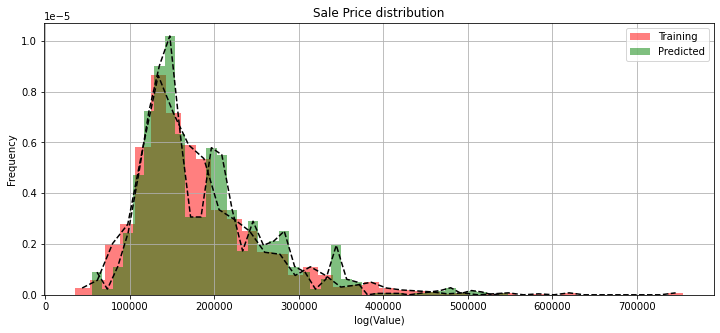

In [24]:
# must convert the y values back
y_out = np.expm1(mm_scaler.inverse_transform(y_test_pred))


fig = plt.figure(figsize=(12,5))

n, bins, patches = plt.hist(df_train[['SalePrice']], 40, facecolor='r', density=True, alpha=0.5, label='Training')
bin_center1 = bins[:-1] + np.diff(bins) / 2
plt.plot(bin_center1,n,'--',c='black')

n, bins, patches = plt.hist(y_out, 40, facecolor='g', density=True, alpha=0.5, label='Predicted')
bin_center = bins[:-1] + np.diff(bins) / 2
plt.plot(bin_center,n,'--',c='black')

plt.xlabel('log(Value)')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
d = {'Id':test_ID, 'SalePrice':y_out.flatten()}

#gender_sub_df = pd.DataFrame(data=d)
gender_sub_df = pd.DataFrame.from_dict(data=d)
gender_sub_df.set_index('Id')

,SalePrice
Id,
1461,125220.289720
1462,151418.601485
1463,196309.459287
1464,212210.679986
1465,202568.660926
...,...
2915,101832.507704
2916,113173.025227
2917,154203.689497


In [26]:
gender_sub_df.to_csv('gender_submission_rf.csv',index=False)